In [10]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks

COLOR = '#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 8 #12
plt.rcParams['ytick.major.size']  = 8 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18
wavelength, flux, err = load_binned_data('/Users/arcticfox/Documents/AUMic/30s/reduced/binned_data_a.npy')
wavelength2, flux2, err2 = load_binned_data('/Users/arcticfox/Documents/AUMic/30s/reduced2/binned_data_a.npy')

times = np.load('/Users/arcticfox/Documents/AUMic/30s/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/30s/reduced/orbits.npy')
times2 = np.load('/Users/arcticfox/Documents/AUMic/30s/reduced2/times.npy')
orbits2 = np.load('/Users/arcticfox/Documents/AUMic/30s/reduced2/orbits.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)

np.append(flux, flux2, axis=0).shape

flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                     allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')#[np.linspace(0,210,len(times),dtype=int)]
distance = (9.79*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times-times[0], times2-times2[0]), 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.measure_FUV130()
for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion=ion)

## Plot Si III and C III flares

6388.016639709473
11990.99193572998
12530.99193572998
16934.99193572998
17984.99193572998
23048.99193572998
1740.0
17514.99206352234
22992.976031303406
23472.976031303406
23652.976031303406
23982.976031303406
24492.976031303406


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


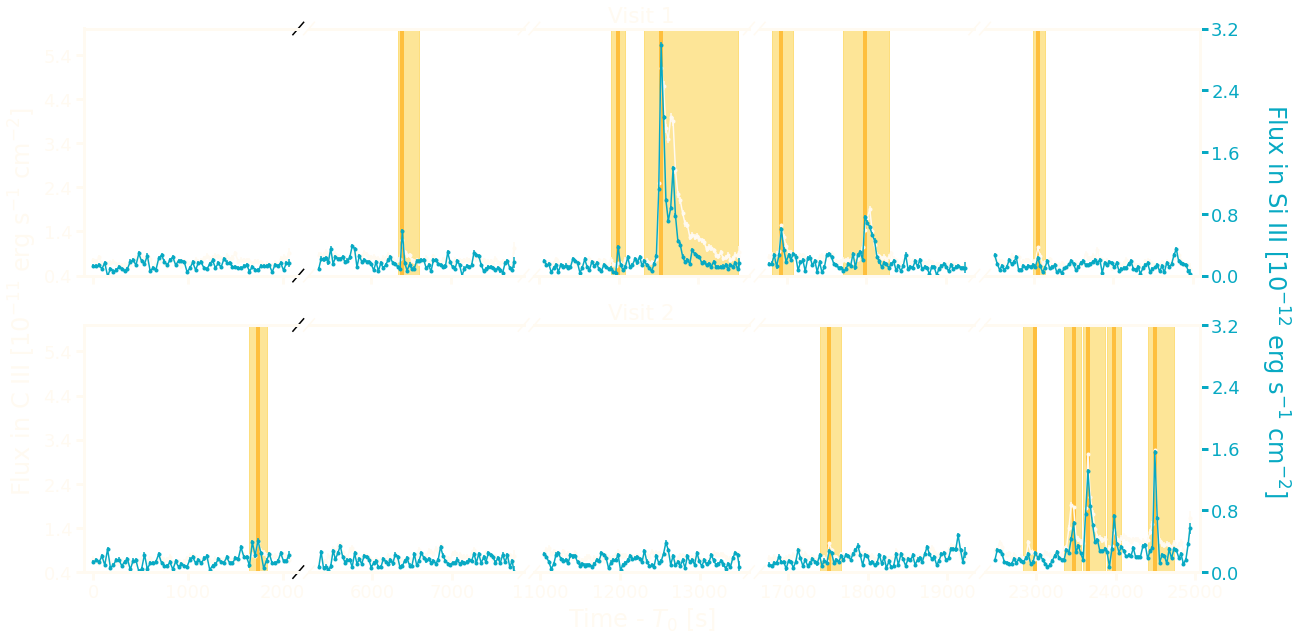

In [14]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,10))
ax = axes.reshape(-1)
fig.set_facecolor('w')

d = .025
c=100

mcolor = COLOR
scolor = parula[100]

for j in range(0,10):
    q = fwc.orbit == j
    ax[j].errorbar(fwc.time[q].value, 
                 fwc.width_table['CIII'][q].value, 
                 yerr=fwc.error_table['CIII'][q].value,
                 color=mcolor, marker='.')
    
    ax2 = ax[j].twinx()
    
    ax2.errorbar(fwc.time[q].value, 
                 fwc.width_table['SiIII'][q].value, 
                 yerr=fwc.error_table['SiIII'][q].value/10,
                 color=scolor, marker='.')
    
    if j in flare_mask[1]:
        inds = np.where(np.array(flare_mask[1])==j)[0]

        for n in inds:
            m = flare_mask[2][n] != 0
            ax[j].axvspan(fwc.time[m][0].value, 
                          fwc.time[m][-1].value, 0, 1,
                          color=parula[225], alpha=0.5)
            
            argmax = np.argmax(fwc.width_table['SiIII'][m])
            ax[j].vlines(fwc.time[m][argmax].value,
                         0, 1, color=parula[215], lw=4)
            print(fwc.time[m][argmax].value)

            c += 15
    
    if j!=0 and j !=4 and j!=5 and j !=9:
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color=COLOR, clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        
    elif j == 0 or j == 5:
        ax[j].spines['right'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color='k', clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
    else:
        ax[j].spines['left'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax[j].set_yticks([])
        #ax2.set_yticks([])
        
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        

    if j == 2:
        ax[j].set_title('Visit 1')#, fontsize=)
    if j == 7:
        ax[j].set_title('Visit 2')
        ax[j].set_xlabel('Time - $T_0$ [s]', fontsize=24)

    if j < 5:
        ax[j].set_xticklabels([])

    if j == 0 or j == 5:
        yticks = np.arange(0.4e-11,6e-11,1e-11)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(np.round(yticks/1e-11, 2))
    if j < 5:
        ax[j].set_xticklabels([])
        ax[j].set_ylim(0.4e-11, 6e-11)
        ax2.set_ylim(0.2e-13, 3e-12)
    else:
        ax[j].set_ylim(0.4e-11, 6e-11)
        ax2.set_ylim(0.2e-13, 3e-12)
    if j == 9 or j == 4:
        yticks = np.arange(0.2e-13, 3.5e-12,8e-13)
        ax2.set_yticks(yticks)
        ax2.tick_params(axis='y', colors=scolor)
        ax2.set_yticklabels(np.round(yticks/1e-12, 1), color=scolor)
        
    if j == 5:
        ax[j].set_ylabel('Flux in C III [$10^{-11}$ erg s$^{-1}$ cm$^{-2}$]', 
                         fontsize=24, y=1.1)
    if j == 9:
        ax[j].set_ylabel('Flux in Si III [$10^{-12}$ erg s$^{-1}$ cm$^{-2}$]\n\n\n\n\n\n\n\n\n\n', 
                       fontsize=24, y=1.1, color=scolor, rotation=270)
    ax[j].set_rasterized(True)
        
plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/arcticfox/Documents/AUMic/paper/flares_dark.png',
            rasterize=True, bbox_inches='tight', dpi=300, transparent=True)

## Plot FUV 130 array

In [8]:
fuv130 = fwc.fuv130 * 4 * np.pi * distance**2

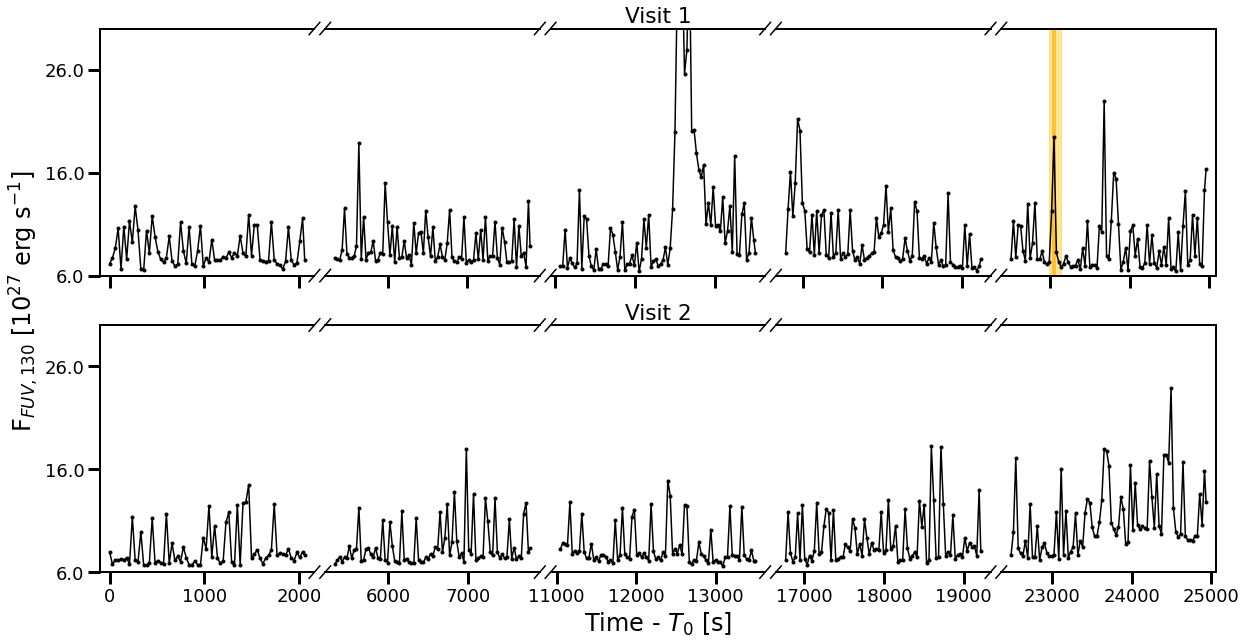

In [49]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,10))
ax = axes.reshape(-1)
fig.set_facecolor('w')

d = .025
c=100

mcolor = 'k'
scolor = parula[80]

for j in range(0,10):
    q = fwc.orbit == j
    ax[j].plot(fwc.time[q].value, 
               fuv130[q], 'k.')
    ax[j].plot(fwc.time[q].value, 
               fuv130[q], 'k')
    
    if j in flare_mask[1]:
        inds = np.where(np.array(flare_orbit)==j)[0]

        for n in inds:
            m = flare_mask[n] != 0
            ax[j].axvspan(fwc.time[m][0].value, 
                          fwc.time[m][-1].value, 0, 1e30,
                          color=parula[225], alpha=0.5)
            
            argmax = np.argmax(fwc.width_table['SiIII'][m])
            ax[j].vlines(fwc.time[m][argmax].value,
                         0, 1e30, color=parula[215], lw=4)

            c += 15
    
    
    if j!=0 and j !=4 and j!=5 and j !=9:
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color='k', clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        
    elif j == 0 or j == 5:
        ax[j].spines['right'].set_visible(False)
        
        kwargs = dict(transform=ax[j].transAxes, color='k', clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
    else:
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        

    if j == 2:
        ax[j].set_title('Visit 1')#, fontsize=)
    if j == 7:
        ax[j].set_title('Visit 2')
        ax[j].set_xlabel('Time - $T_0$ [s]', fontsize=24)

    if j < 5:
        ax[j].set_xticklabels([])

    ylow = 0.6e28
    yupp = 3e28

    if j == 0 or j == 5:
        yticks = np.arange(ylow, yupp,1e28)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(np.round(yticks/1e27, 2))
    if j < 5:
        ax[j].set_xticklabels([])
        ax[j].set_ylim(ylow, yupp)
    else:
        ax[j].set_ylim(ylow, yupp)


        
    if j == 5:
        ax[j].set_ylabel('F$_{FUV,130}$ [$10^{27}$ erg s$^{-1}$]', 
                         fontsize=24, y=1.1)

    
    ax[j].set_rasterized(True)
        
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/arcticfox/Documents/AUMic/paper/flares.pdf',
#            rasterize=True, bbox_inches='tight', dpi=300)

In [52]:
qmask = np.nansum(np.array(flare_mask),axis=0) == 0
for i in range(len(flare_orbit)):
    #qmask = np.where((fwc.orbit==flare_orbit[i]) & (flare_mask[i]==0))[0]
    fmask = flare_mask[i] != 0
    e,d = fwc.measure_flare_params(fmask=fmask, qmask=qmask,
                                   d=distance)
    print(np.abs(e*10e-13),d)

5.0449822866014285e+30 erg 65.0568032894816 s
4.412243330478056e+29 erg -5.689741412543352 s
8.817472973348727e+31 erg 1137.0438430694692 s
1.7590599608376449e+31 erg 226.8369071394897 s
8.562457472656096e+30 erg 110.41587062704947 s
4.662734449183557e+30 erg 60.12758432418045 s
1.4540147171449508e+30 erg 18.75002607730336 s
1.9354942226574503e+30 erg 24.958871955956532 s
3.6120995395986984e+29 erg 4.657928132548561 s
6.258013894157599e+30 erg 80.69926825636408 s
1.4457515660670794e+31 erg 186.43469866857967 s
7.079340101544057e+30 erg 91.29055569306033 s
1.8691523148685329e+31 erg 241.03369954227995 s
